In [14]:
# For downloading the excel sheet and other metadata files
import requests
url = 'https://raw.githubusercontent.com/uncbiag/OAI_analysis/55b0a91d180a54dc56e35e9176ac1f75d2cd7f6b/data/Enrollees.txt'
r = requests.get(url, allow_redirects=True)
open('Enrollees.txt', 'wb').write(r.content)

url = 'https://raw.githubusercontent.com/uncbiag/OAI_analysis/master/data/SEG_3D_DESS_all.csv'
r = requests.get(url, allow_redirects=True)
open('SEG_3D_DESS_all.csv', 'wb').write(r.content)

4985154

In [2]:
import os
import sys
from functools import reduce
from shutil import copyfile
import pandas as pd
import SimpleITK as sitk


class OAIData:
    def __init__(self, data_sheet=None, raw_data_root=None):
        self.images = list() # a list of OAIImage objects
        self.visit_description = {-1: 'SCREENING',  # only exists in Xray images
                                  0: 'ENROLLMENT',
                                  12: '12 MONTH',
                                  24: '24 MONTH',
                                  36: '36 MONTH',
                                  48: '48 MONTH',
                                  72: '72 MONTH',
                                  96: '96 MONTH'}
        self.root_path = None  # root path of data and initialized when building patient repositories
        self.patient_set = set()
        if data_sheet != None and raw_data_root != 'None':
            print('Data Sheet is ', data_sheet)
            self.load_raw_data_sheet(data_sheet, raw_data_root=raw_data_root)
        else:
            print("WARNING: the OAI data is not correctly initialized since both data_sheet and raw_data_root are required!")

    def load_raw_data_sheet(self, data_sheet, raw_data_root='', proceesed_data_root=''):
        """
        load images info from a data sheet
        raw_data_root is the root path of raw OAI images
        :param data_sheet: data sheet whose entries(rows) are info of each image
        The columns of sheet are:
            Folder,ParticipantID,StudyDate,Barcode,StudyDescription,SeriesDescription
        :param raw_data_root: root path the raw image data
        :return:
        """
        self.df = pd.read_csv(data_sheet)

        for df_line in self.df.itertuples(index=False):
            image = OAIImage(df_line, raw_data_root)
            self.images.append(image)
            self.patient_set.add(image.patient_id)

    def set_processed_data_paths(self, proceesed_data_root='',task_name=None):
        """Set the root folder where the processed data are saved"""
        self.root_path = proceesed_data_root
        for image in self.images:
            image.set_processed_data_paths(proceesed_data_root,task_name)

    def set_processed_data_paths_without_creating_image_directories(self, proceesed_data_root='',task_name=None):
        """Set the root folder where the processed data are saved"""
        self.root_path = proceesed_data_root
        for image in self.images:
            image.set_processed_data_paths_without_creating_directories(proceesed_data_root,task_name)


    def build_repositories(self):
        """
        Build nested repositories for patients to save processed OAI data
        e.g. intermediate results and add preprocessed images
        The structure of repositories are :
        -patient_ids
            -modalities (e.g. MR_SAG_3D_DESS ...)
                -parts (e.g. 'LEFT KNEE', 'RIGHT KNEE' ...)
                    -visits (e.g. 'ENROLLMENT', '12 MONTH', ...)
                        -image (e.g. 'image_normalized.nii.gz')
                        -segmentation folder (named by the CNN segmentation checkpoint name)
                            - segmentation results: cartilage_FC_TC_mask,
                            - meshes of cartilages:
        """

        for image in self.images:
            if not os.path.exists(image.folder):
                os.makedirs(image.folder, exist_ok=True)

    # def preprocess_images(self, old_normalized_image_folder=None, overwrite=False):
    #     """preprocess raw images and save them into corresponding folders"""
    #     images = self.get_images()
    #     for image in images:
    #         image.preprocessed_image_file = os.path.join(image.folder, "image_normalized.nii.gz")
    #
    #         os.makedirs(image.folder, exist_ok=True)
    #         if overwrite or (not os.path.isfile(image.preprocessed_image_file)) :
    #             # if there were processed image saved in a single folder, copy them into the folder
    #             if old_normalized_image_folder:
    #                 old_normalized_image_file_name = "{}_{}_{}_{}_image.nii.gz".format(image.patient_id,
    #                                                                             image.study_date,
    #                                                                             image.series_description,
    #                                                                             image.bar_code)
    #                 old_normalized_image_file_path = os.path.join(old_normalized_image_folder, old_normalized_image_file_name)
    #                 print("Copying {} to {}".format(old_normalized_image_file_path, image.preprocessed_image_file))
    #                 copyfile(old_normalized_image_file_path, image.preprocessed_image_file)
    #             else:
    #                 # TODO: load images from raw folders and do preprocessing
    #                 # preprocess(visit['raw_folder'], tmp_new_image_path)
    #                 pass


    def clean_data(self):
        # clean dataset by checking the consistency of resolution
        """
        abnormal example list:
        !! image size not matched , img:9901199_20090422_SAG_3D_DESS_RIGHT_12800503_image.nii.gz sz:(160, 384, 352)
        !! image size not matched , img:9052335_20090126_SAG_3D_DESS_RIGHT_12766414_image.nii.gz sz:(176, 384, 384)
        !! image size not matched , img:9163391_20110808_SAG_3D_DESS_LEFT_16613250603_image.nii.gz sz:(159, 384, 384)
        !! image size not matched , img:9712762_20090420_SAG_3D_DESS_RIGHT_12583306_image.nii.gz sz:(160, 384, 352)
        !! image size not matched , img:9388265_20040405_SAG_3D_DESS_LEFT_10016906_image.nii.gz sz:(176, 384, 384)
        !! image size not matched , img:9388265_20040405_SAG_3D_DESS_LEFT_10016903_image.nii.gz sz:(176, 384, 384)
        !! image size not matched , img:9938453_20071130_SAG_3D_DESS_RIGHT_12140103_image.nii.gz sz:(159, 384, 384)
        !! image size not matched , img:9452305_20070228_SAG_3D_DESS_RIGHT_11633112_image.nii.gz sz:(109, 384, 384)
        !! image size not matched , img:9219500_20080326_SAG_3D_DESS_RIGHT_12266509_image.nii.gz sz:(8, 384, 384)
        !! image size not matched , img:9011949_20060118_SAG_3D_DESS_LEFT_10667703_image.nii.gz sz:(156, 384, 384)
        !! image size not matched , img:9885303_20051212_SAG_3D_DESS_LEFT_10624403_image.nii.gz sz:(155, 384, 384)
        !! image size not matched , img:9833782_20090519_SAG_3D_DESS_RIGHT_12802313_image.nii.gz sz:(176, 384, 384)
        !! image size not matched , img:9462278_20050524_SAG_3D_DESS_RIGHT_10546912_image.nii.gz sz:(156, 384, 384)
        !! image size not matched , img:9126260_20060921_SAG_3D_DESS_RIGHT_11309309_image.nii.gz sz:(66, 384, 384)
        !! image size not matched , img:9487462_20081003_SAG_3D_DESS_RIGHT_11495603_image.nii.gz sz:(176, 384, 384)
        !! image size not matched , img:9847480_20081007_SAG_3D_DESS_RIGHT_11508512_image.nii.gz sz:(159, 384, 384)
        !! image size not matched , img:9020714_20101207_SAG_3D_DESS_RIGHT_16613171935_image.nii.gz sz:(118, 384, 384)
        """

        series_to_clean = []
        series = self.get_image_series()
        for single_series in series:
            if not self._check_images_resolution_consistency(list(single_series.values())):
                print("{}_{}_{} series have inconsistent resolutions!".format(single_series[0].get_brief_info[0],
                                                                              single_series[0].get_brief_info[1],
                                                                              single_series[0].get_brief_info[2]))
                for image in single_series.values:
                    self.images.remove(image)



    def _check_images_resolution_consistency(self, image_series):
        """check the images of patients and return if their resolutions are consistent"""
        assert isinstance(image_series, list), "input has to be a list"
        resolutions = set()
        for image in image_series:
            image_path = image.preprocessed_image_path
            tmp_img = sitk.Image()
            if os.path.isdir(image_path):
                reader = sitk.ImageSeriesReader()
                dicom_names = reader.GetGDCMSeriesFileNames(image_path)
                _ = reader.SetFileNames(dicom_names)
                tmp_img = reader.Execute()
            elif os.path.isfile(image_path):
                tmp_img = sitk.ReadImage(tmp_img)
            else:
                ValueError("No such a file or path at {}".format(tmp_img))
            resolutions.add(tmp_img.GetSize())
        if len(resolutions) == 1:
            return True
        elif len(resolutions) > 1:
            return False
        else:
            ValueError("Error in checking resolutions")

    def get_patient_list(self):
        return list(self.patient_set)

    def get_images(self, **kwargs):
        """
        Get a list of images that meets sepecific requirements e.g. patient_id, modality, body part, visit time et.al.
        Optional
        :param patient_id (list of ints): requested patient ids for all patients, e.g. [9010952,...]
        :param modality (list of strings): requested modalities or None for all modalities e.g. ['MR_SAG_3D_DESS']
        :param part (list of strings): requested body parts or None for all parts e.g. ['LEFT KNEE', 'RIGHT_KNEE', ..]
        :param visit_month (list of ints): visiting time (count of months) e.g. [0, 12, 24, ...]
        :return: a list of images
        Warning!: The returned data are the references of data in the object, any change on them will affect the object
        """
        conditions = {key:value for key, value in kwargs.items() if value is not None}

        images = [image for image in self.images if image.filter(conditions)]

        return images

    def get_image_series(self, with_series_description, **kwargs):
        """
        Get a list of image series of specific patients, modalities and body parts of all visiting times.
        Optional:
        :param patient_id (list of ints): requested patient ids for all patients, e.g. [9010952,...]
        :param modality (list of strings): requested modalities or None for all modalities e.g. ['MR_SAG_3D_DESS']
        :param part (list of strings): requested body parts or None for all parts e.g. ['LEFT KNEE', 'RIGHT_KNEE', ..]
        :return:if with_series_description is True: return a list of pairs of series and series_info from following two:
                    images_series (a list of dictionaries): image series which are dictionaries with visiting num as keys
                    image_series_info (a list of tuples): list of (image patient_id, modality, part)
                Otherwise just return image_series
        Warning!!!The returned data are the references of data in the object, any change on them will affect the object
        """
        images_series = []
        image_series_info = []
        for image in self.images:
            if image.filter(kwargs):
                image_info = image.get_brief_info()
                series_info = image_info[:-1]
                visit = image_info[-1]
                try:
                    # if a series containing this image exists
                    images_series[image_series_info.index(series_info)][visit] = image
                except ValueError:
                    images_series.append({visit: image})
                    image_series_info.append(series_info)
        if with_series_description:
            return [(image_series_info[i], images_series[i]) for i in range(len(image_series_info))]
        else:
            return images_series

    def get_image_series_attributes(self, patient_id, modality, part, attribute):
        """
        Get attributes of a series of image of specific patient at all visiting times, with given modalities, parts.
        """
        # TODO: may not needed
        pass
        # image_paths = {}
        # for visit_num in self.images[patient_id][modality][part]:
        #     image_paths[visit_num] = self.images[patient_id][modality][part][visit_num][attribute]
        # return image_paths

    def get_processed_data_frame(self):
        """generate a data frame from processed image info"""
        df_lines = [image.get_dataframe_line() for image in self.images]
        return pd.concat(df_lines).reset_index()

    def save_datasheet(self, file_name):
        """
        save current image infos into .csv datasheet
        :param file_name:
        :return:
        """
        self.get_processed_data_frame().to_csv(file_name)

class OAIImage:

    def __init__(self, df_line=None, raw_root=None):
        # attributes from raw OAI data
        self.raw_folder = None
        self.patient_id = None
        self.study_date = None
        self.bar_code = None
        self.modality= None
        self.part = None
        self.visit_month = None
        self.visit_description = {-1: 'SCREENING',  # only exists in Xray images
                                  0: 'ENROLLMENT',
                                  12: '12_MONTH',
                                  24: '24_MONTH',
                                  36: '36_MONTH',
                                  48: '48_MONTH',
                                  72: '72_MONTH',
                                  96: '96_MONTH'}

        # attributes of analysis file paths
        self.folder = None
        self.preprocessed_image_file = None
        self.FC_probmap_file = None
        self.TC_probmap_file = None
        self.FC_mesh_file = None
        self.TC_mesh_file = None
        self.affine_transform_file = None
        self.bspline_transform_file = None
        self.warped_FC_mesh_file = None
        self.warped_TC_mesh_file = None
        self.inv_transform_to_atlas = None
        self.FC_thickness_mapped_to_atlas_mesh = None
        self.TC_thickness_mapped_to_atlas_mesh = None
        self.FC_2D_thickness_grid = None
        self.TC_2D_thickness_grid = None

        if df_line:
            self.patient_id = df_line.ParticipantID
            self.study_date = df_line.StudyDate
            self.bar_code = df_line.Barcode
            self.modality, self.part, self.visit_month = self.factor_description(df_line.StudyDescription,
                                                                                 df_line.SeriesDescription)
            if raw_root:
                self.raw_folder = os.path.join(raw_root, df_line.Folder)



    @property
    def name(self):
        return "_".join([str(self.patient_id), self.visit_description[self.visit_month], self.part, self.modality])

    def create_output_directory(self,task_name=None):
        task_folder = os.path.join(self.folder, task_name) if task_name else self.folder
        os.makedirs(task_folder, exist_ok=True)

    def set_processed_data_paths_without_creating_directories(self, processed_root,task_name=None):
        """
        According to the root path of processed data, setup the path of all analysis file
        :param processed_root:
        :return:
        """
        if self.folder is None:
            self.folder = os.path.join(processed_root,
                                       str(self.patient_id) if (self.patient_id is not None) else '',
                                       self.modality if (self.modality is not None) else '',
                                       self.part if (self.part is not None) else '',
                                       self.visit_description[self.visit_month] if (self.visit_month is not None ) else '')

        task_folder = os.path.join(self.folder,task_name) if task_name else self.folder

        self.preprocessed_image_file = os.path.join(self.folder, 'image_preprocessed.nii.gz')
        self.FC_probmap_file = os.path.join(self.folder, 'FC_probmap.nii.gz')
        self.TC_probmap_file = os.path.join(self.folder, 'TC_probmap.nii.gz')
        self.FC_mesh_file = os.path.join(task_folder, "FC_mesh_world.ply")
        self.TC_mesh_file = os.path.join(task_folder, "TC_mesh_world.ply")
        self.affine_transform_file = os.path.join(self.folder, "affine_transform_to_atlas.txt")
        self.bspline_transform_file = os.path.join(self.folder, "bspline_control_points_to_atlas.nii.gz")
        self.warped_FC_mesh_file = os.path.join(task_folder, "FC_mesh_world_to_atlas.ply")
        self.warped_TC_mesh_file = os.path.join(task_folder, "TC_mesh_world_to_atlas.ply")
        self.inv_transform_to_atlas = os.path.join(task_folder, "inv_transform_to_atlas.nii.gz")
        self.FC_thickness_mapped_to_atlas_mesh = os.path.join(task_folder, "atlas_FC_mesh_with_thickness.ply")
        self.TC_thickness_mapped_to_atlas_mesh = os.path.join(task_folder, "atlas_TC_mesh_with_thickness.ply")

        self.FC_2D_thickness_grid = os.path.join(task_folder, "FC_2d_thickness.npy")
        self.TC_2D_thickness_grid = os.path.join(task_folder, "TC_2d_thickness.npy")


    def set_processed_data_paths(self, processed_root,task_name=None):
        """
        According to the root path of processed data, setup the path of all analysis file
        :param processed_root:
        :return:
        """
        self.set_processed_data_paths_without_creating_directories(processed_root=
                                                                   processed_root, task_name=task_name)

        self.create_output_directory(task_name=task_name)




    def get_dataframe_line(self):
        return pd.DataFrame([self.__dict__])

    def get_all_attributes(self):
        return self.__dict__

    def get_brief_info(self):
        """Get the patient_id, modality, part, and visit_info of a image"""
        return (self.patient_id, self.modality, self.part, self.visit_month)


    def filter(self, kwargs):
        """
        filter image by given allowed attributes value, e.g. image.filter({'patient_id':[9010952]})
        :param kwargs: a dictionary with image attribute names as keys and the allowed values (as list) as dict values.
                    For example, {'patient_id':[9010952, 9010953], 'part':['LEFT KNEE', 'RIGHT KNEE']}
        :return: True if all filter condition meets
        """
        if kwargs:
            return reduce(lambda x, y: x & y, [self.__getattribute__(key) in value for key, value in kwargs.items()],
                          True)
        else:
            return True

    @staticmethod
    def factor_description(study_description, series_description):
        """
        factorize image descriptions in OAI data sheets and return its modality, visit date, and imaging part
        :param study_description:
        :param series_description:
        :return:
        """
        study_factors = study_description.rstrip().replace('Thigh', 'THIGH').split(
            '^')  # clean descriptions capitalization

        part = study_factors[-1]

        if study_factors[2] == 'SCREENING':
            visit_mon = -1
        elif study_factors[2] == 'ENROLLMENT':
            visit_mon = 0
        else:
            visit_mon = int(study_factors[2].split(' ')[0])

        modality = study_factors[1]

        if modality == "MR":
            series_factor = series_description.split('_')
            # add specific modality info
            if len(series_factor) > 1:
                modality = '_'.join([modality] + series_factor[:-1])
            else:
                modality = '_'.join([modality] + series_factor)

            # LEFT or RIGHT in MR images mean for knee only
            if part == "LEFT" or part == "RIGHT":
                part = part + '_'+'KNEE'
        return modality, part, visit_mon

    def __repr__(self):
        return self.name

class OAIPatients:
    """
    interface to visit patient info chart
    useful attributes:
    'P02RACE': race,
        e.g. '1: White or Caucasian', '2: Black or African American',
            '0: Other Non-white', '3: Asian', '.: Missing Form/Incomplete Workbook'
    'P02SEX': sex,
        e.g. '1: Male', '2: Female'
    'V00COHORT': cohort,
        e.g. '1: Progression', '2: Incidence', '3: Non-exposed control group'
    """
    def __init__(self, enrollees_text_file):
        df = pd.read_csv(enrollees_text_file, sep='|')
        self.df = df.set_index('ID')

    def filter_patient(self, **kwargs):
        df_bool = reduce(lambda x, y: x & y, [self.df[key] == value for key, value in kwargs.items()],
               True)
        return set(self.df.index[df_bool])

    def get_all_attributes(self):
        return self.df.keys()

    def get_unique_attribute_values(self, attribute):
        return self.df[attribute].unique()

def oai_data_test():
    """
    Analyze OAI MR images, including
    - Intensity normalization
    - Femoral/Tibial cartilage segmentation using CNNs
    - Generating cartilage surface meshes from segmentation results
    - Computing (per-vertex) thickness of cartilage
    """
    # set GPU
    os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
    os.environ["CUDA_VISIBLE_DEVICES"] = '1'
    os.environ["CUDA_CACHE_PATH"] = "/playpen/zhenlinx/.cuda_cache"

    # patient infos
    patients_ASCII_file_path = "./Enrollees.txt"
    # patients_df = pd.read_table(patients_ASCII_file_path, sep='|')
    # patients_df = patients_df.set_index('ID')
    # progression_cohort = list(patients_df.index[patients_df['V00COHORT'] == '1: Progression'])

    oai_patients = OAIPatients(patients_ASCII_file_path)
    progression_cohort = oai_patients.filter_patient(V00COHORT='1: Progression')

    # image_folder_path = "/playpen-raid/zhenlinx/Data/OAI_segmentation/Nifti_6sets_rescaled"
    # OAI_data_sheet = "/playpen-raid/zhenlinx/Data/OAI_segmentation/SEG_3D_DESS_6sets_40test.csv"
    OAI_data_sheet = "./SEG_3D_DESS_all.csv"

    OAI_data = OAIData(OAI_data_sheet, '/home/pranjal.sahu/Downloads/OAI-RAW-DATA')
    # OAI_data.set_processed_data_paths()
    ## build repositories and preprocess the raw image data
    OAI_data.set_processed_data_paths_without_creating_image_directories('/home/pranjal.sahu/Downloads/OAI-RAW-DATA')
    images = OAI_data.get_images()
    series = OAI_data.get_image_series()
    df = OAI_data.get_processed_data_frame()


#if __name__ == '__main__':
#    oai_data_test()

In [12]:
# For pre-processing the images before performing segmentation
import numpy as np

def image_normalize(image, window_min_perc, window_max_perc, output_min, output_max):
    window_rescale = sitk.IntensityWindowingImageFilter()
    image_array = sitk.GetArrayFromImage(image)
    
    window_min = np.percentile(image_array, window_min_perc)
    window_max = np.percentile(image_array, window_max_perc)
    
    window_rescale.SetOutputMaximum(output_max)
    window_rescale.SetOutputMinimum(output_min)
    window_rescale.SetWindowMaximum(window_max)
    window_rescale.SetWindowMinimum(window_min)
    return window_rescale.Execute(image)

def label2image(label_array, source_image):
    label_image = sitk.GetImageFromArray(label_array.astype('uint8'))
    label_image.CopyInformation(source_image)
    return label_image

reader = sitk.ImageSeriesReader()
dicom_names = reader.GetGDCMSeriesFileNames('/home/pranjal.sahu/Downloads/OAI-RAW-DATA/9298954_20050422_10384312_right')

print("Read {} DICOM slices in {}".format(len(dicom_names), '/home/pranjal.sahu/Downloads/OAI-RAW-DATA/9298954_20050422_10384312_right'))
reader.SetFileNames(dicom_names)
image = reader.Execute()
image = sitk.Cast(image, sitk.sitkFloat32)

if_corrected = False  # if do bias field correction
if_normalize = False
if_crop      = False
flip_side    = "RIGHT"
all_sides    = ["RIGHT", "LEFT"]
    
# # bias field correction
# if self.bias_correct:
#     # if want to use all voxels
#     all_mask = label2image(np.ones(sitk.GetArrayFromImage(image).shape).astype(int), image)

#     image = sitk.Add(image, 1)
#     image = sitk.N4BiasFieldCorrection(image, all_mask)
#     image = sitk.Subtract(image, 1)

# # rescale the intensity
if True:#self.normalize_intensity:
    #print("Normalizing: {}".format(oai_image.name))
    image = image_normalize(image, 0.1, 99.9, 0, 1)

# # reset original and orientation
# if True:#self.reset_coord:
#     # reset original and orientation
#     print("reset coordinates: {}".format(oai_image.name))
#     reset_sitk_image_coordinates(image, [0, 0, 0], [0, 0, -1, 1, 0, 0, 0, -1, 0])

# # flip the left and right:
# # if self.flip_to and (self.flip_to not in oai_image.part):
# #     print("flipping {}".format(oai_image.name))
# #     image = flip_left_right(image)


Read 160 DICOM slices in /home/pranjal.sahu/Downloads/OAI-RAW-DATA/9298954_20050422_10384312_right


In [15]:
image1 = sitk.GetArrayFromImage(image)
print(image1.shape)

(160, 384, 384)


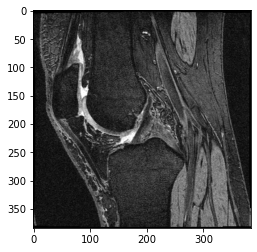

In [16]:
import matplotlib.pyplot as plt
plt.imshow(image1[80, :, :], cmap='gray')

In [4]:
print(all_mask.GetPixelIDTypeAsString())
print(image.GetPixelIDTypeAsString())
print(image.GetSize())

8-bit unsigned integer
32-bit float
(384, 384, 160)


In [ ]:
help(sitk.N4BiasFieldCorrection)

In [21]:
OAI_data.set_processed_data_paths_without_creating_image_directories('/home/pranjal.sahu/Downloads/OAI-RAW-DATA')

In [16]:
OAI_data_sheet = "./SEG_3D_DESS_all.csv"
OAI_data = OAIData(OAI_data_sheet, '/home/pranjal.sahu/Downloads/OAI-RAW-DATA')

Data Sheet is  ./SEG_3D_DESS_all.csv


In [ ]:
df = OAI_data.get_processed_data_frame()
print(df)

In [29]:
series = OAI_data.get_image_series(with_series_description=False, patient_id=[9298954])
print(len(series))

for k in series:
    print(k)

2
{0: 9298954_ENROLLMENT_LEFT_KNEE_MR_SAG_3D_DESS, 12: 9298954_12_MONTH_LEFT_KNEE_MR_SAG_3D_DESS, 24: 9298954_24_MONTH_LEFT_KNEE_MR_SAG_3D_DESS, 36: 9298954_36_MONTH_LEFT_KNEE_MR_SAG_3D_DESS, 48: 9298954_48_MONTH_LEFT_KNEE_MR_SAG_3D_DESS, 72: 9298954_72_MONTH_LEFT_KNEE_MR_SAG_3D_DESS, 96: 9298954_96_MONTH_LEFT_KNEE_MR_SAG_3D_DESS}
{0: 9298954_ENROLLMENT_RIGHT_KNEE_MR_SAG_3D_DESS, 12: 9298954_12_MONTH_RIGHT_KNEE_MR_SAG_3D_DESS, 24: 9298954_24_MONTH_RIGHT_KNEE_MR_SAG_3D_DESS, 36: 9298954_36_MONTH_RIGHT_KNEE_MR_SAG_3D_DESS, 48: 9298954_48_MONTH_RIGHT_KNEE_MR_SAG_3D_DESS, 72: 9298954_72_MONTH_RIGHT_KNEE_MR_SAG_3D_DESS, 96: 9298954_96_MONTH_RIGHT_KNEE_MR_SAG_3D_DESS}


In [25]:
images = OAI_data.get_images()
print(len(images))

for i, k in enumerate(images):
    print(i, k)

48072
0 9000099_ENROLLMENT_LEFT_KNEE_MR_SAG_3D_DESS
1 9000099_12_MONTH_LEFT_KNEE_MR_SAG_3D_DESS
2 9000099_24_MONTH_LEFT_KNEE_MR_SAG_3D_DESS
3 9000099_36_MONTH_LEFT_KNEE_MR_SAG_3D_DESS
4 9000099_48_MONTH_LEFT_KNEE_MR_SAG_3D_DESS
5 9000099_72_MONTH_LEFT_KNEE_MR_SAG_3D_DESS
6 9000099_96_MONTH_LEFT_KNEE_MR_SAG_3D_DESS
7 9000099_ENROLLMENT_RIGHT_KNEE_MR_SAG_3D_DESS
8 9000099_12_MONTH_RIGHT_KNEE_MR_SAG_3D_DESS
9 9000099_24_MONTH_RIGHT_KNEE_MR_SAG_3D_DESS
10 9000099_36_MONTH_RIGHT_KNEE_MR_SAG_3D_DESS
11 9000099_48_MONTH_RIGHT_KNEE_MR_SAG_3D_DESS
12 9000099_72_MONTH_RIGHT_KNEE_MR_SAG_3D_DESS
13 9000099_96_MONTH_RIGHT_KNEE_MR_SAG_3D_DESS
14 9000296_ENROLLMENT_LEFT_KNEE_MR_SAG_3D_DESS
15 9000296_12_MONTH_LEFT_KNEE_MR_SAG_3D_DESS
16 9000296_36_MONTH_LEFT_KNEE_MR_SAG_3D_DESS
17 9000296_48_MONTH_LEFT_KNEE_MR_SAG_3D_DESS
18 9000296_72_MONTH_LEFT_KNEE_MR_SAG_3D_DESS
19 9000296_96_MONTH_LEFT_KNEE_MR_SAG_3D_DESS
20 9000296_ENROLLMENT_RIGHT_KNEE_MR_SAG_3D_DESS
21 9000296_12_MONTH_RIGHT_KNEE_MR_SAG_3D_DE

3539 9079404_ENROLLMENT_RIGHT_KNEE_MR_SAG_3D_DESS
3540 9079404_ENROLLMENT_RIGHT_KNEE_MR_SAG_3D_DESS
3541 9079404_12_MONTH_RIGHT_KNEE_MR_SAG_3D_DESS
3542 9079404_24_MONTH_RIGHT_KNEE_MR_SAG_3D_DESS
3543 9079404_36_MONTH_RIGHT_KNEE_MR_SAG_3D_DESS
3544 9079404_48_MONTH_RIGHT_KNEE_MR_SAG_3D_DESS
3545 9080864_ENROLLMENT_LEFT_KNEE_MR_SAG_3D_DESS
3546 9080864_12_MONTH_LEFT_KNEE_MR_SAG_3D_DESS
3547 9080864_ENROLLMENT_RIGHT_KNEE_MR_SAG_3D_DESS
3548 9080864_12_MONTH_RIGHT_KNEE_MR_SAG_3D_DESS
3549 9081306_ENROLLMENT_LEFT_KNEE_MR_SAG_3D_DESS
3550 9081306_12_MONTH_LEFT_KNEE_MR_SAG_3D_DESS
3551 9081306_24_MONTH_LEFT_KNEE_MR_SAG_3D_DESS
3552 9081306_ENROLLMENT_RIGHT_KNEE_MR_SAG_3D_DESS
3553 9081306_12_MONTH_RIGHT_KNEE_MR_SAG_3D_DESS
3554 9081306_24_MONTH_RIGHT_KNEE_MR_SAG_3D_DESS
3555 9081306_36_MONTH_RIGHT_KNEE_MR_SAG_3D_DESS
3556 9081362_ENROLLMENT_LEFT_KNEE_MR_SAG_3D_DESS
3557 9081362_12_MONTH_LEFT_KNEE_MR_SAG_3D_DESS
3558 9081362_24_MONTH_LEFT_KNEE_MR_SAG_3D_DESS
3559 9081362_36_MONTH_LEFT_KNEE_MR

6686 9159961_96_MONTH_LEFT_KNEE_MR_SAG_3D_DESS
6687 9159961_ENROLLMENT_RIGHT_KNEE_MR_SAG_3D_DESS
6688 9159961_12_MONTH_RIGHT_KNEE_MR_SAG_3D_DESS
6689 9159961_24_MONTH_RIGHT_KNEE_MR_SAG_3D_DESS
6690 9159961_36_MONTH_RIGHT_KNEE_MR_SAG_3D_DESS
6691 9159961_48_MONTH_RIGHT_KNEE_MR_SAG_3D_DESS
6692 9159961_72_MONTH_RIGHT_KNEE_MR_SAG_3D_DESS
6693 9159961_96_MONTH_RIGHT_KNEE_MR_SAG_3D_DESS
6694 9160026_48_MONTH_LEFT_KNEE_MR_SAG_3D_DESS
6695 9160026_ENROLLMENT_RIGHT_KNEE_MR_SAG_3D_DESS
6696 9160026_12_MONTH_RIGHT_KNEE_MR_SAG_3D_DESS
6697 9160026_24_MONTH_RIGHT_KNEE_MR_SAG_3D_DESS
6698 9160026_36_MONTH_RIGHT_KNEE_MR_SAG_3D_DESS
6699 9160026_48_MONTH_RIGHT_KNEE_MR_SAG_3D_DESS
6700 9160270_ENROLLMENT_LEFT_KNEE_MR_SAG_3D_DESS
6701 9160270_12_MONTH_LEFT_KNEE_MR_SAG_3D_DESS
6702 9160270_24_MONTH_LEFT_KNEE_MR_SAG_3D_DESS
6703 9160270_36_MONTH_LEFT_KNEE_MR_SAG_3D_DESS
6704 9160270_48_MONTH_LEFT_KNEE_MR_SAG_3D_DESS
6705 9160270_72_MONTH_LEFT_KNEE_MR_SAG_3D_DESS
6706 9160270_96_MONTH_LEFT_KNEE_MR_SAG_3D_

10014 9242547_72_MONTH_RIGHT_KNEE_MR_SAG_3D_DESS
10015 9242547_96_MONTH_RIGHT_KNEE_MR_SAG_3D_DESS
10016 9242653_ENROLLMENT_LEFT_KNEE_MR_SAG_3D_DESS
10017 9242653_ENROLLMENT_RIGHT_KNEE_MR_SAG_3D_DESS
10018 9242925_ENROLLMENT_LEFT_KNEE_MR_SAG_3D_DESS
10019 9242925_12_MONTH_LEFT_KNEE_MR_SAG_3D_DESS
10020 9242925_24_MONTH_LEFT_KNEE_MR_SAG_3D_DESS
10021 9242925_48_MONTH_LEFT_KNEE_MR_SAG_3D_DESS
10022 9242925_ENROLLMENT_RIGHT_KNEE_MR_SAG_3D_DESS
10023 9242925_12_MONTH_RIGHT_KNEE_MR_SAG_3D_DESS
10024 9242925_24_MONTH_RIGHT_KNEE_MR_SAG_3D_DESS
10025 9242925_36_MONTH_RIGHT_KNEE_MR_SAG_3D_DESS
10026 9242925_48_MONTH_RIGHT_KNEE_MR_SAG_3D_DESS
10027 9242956_ENROLLMENT_LEFT_KNEE_MR_SAG_3D_DESS
10028 9242956_36_MONTH_LEFT_KNEE_MR_SAG_3D_DESS
10029 9242956_ENROLLMENT_RIGHT_KNEE_MR_SAG_3D_DESS
10030 9242956_36_MONTH_RIGHT_KNEE_MR_SAG_3D_DESS
10031 9243046_ENROLLMENT_LEFT_KNEE_MR_SAG_3D_DESS
10032 9243046_12_MONTH_LEFT_KNEE_MR_SAG_3D_DESS
10033 9243046_24_MONTH_LEFT_KNEE_MR_SAG_3D_DESS
10034 9243046_36

13788 9321092_ENROLLMENT_RIGHT_KNEE_MR_SAG_3D_DESS
13789 9321092_12_MONTH_RIGHT_KNEE_MR_SAG_3D_DESS
13790 9321092_24_MONTH_RIGHT_KNEE_MR_SAG_3D_DESS
13791 9321092_36_MONTH_RIGHT_KNEE_MR_SAG_3D_DESS
13792 9321092_48_MONTH_RIGHT_KNEE_MR_SAG_3D_DESS
13793 9321092_72_MONTH_RIGHT_KNEE_MR_SAG_3D_DESS
13794 9321092_96_MONTH_RIGHT_KNEE_MR_SAG_3D_DESS
13795 9321373_ENROLLMENT_LEFT_KNEE_MR_SAG_3D_DESS
13796 9321373_12_MONTH_LEFT_KNEE_MR_SAG_3D_DESS
13797 9321373_24_MONTH_LEFT_KNEE_MR_SAG_3D_DESS
13798 9321373_48_MONTH_LEFT_KNEE_MR_SAG_3D_DESS
13799 9321373_72_MONTH_LEFT_KNEE_MR_SAG_3D_DESS
13800 9321373_96_MONTH_LEFT_KNEE_MR_SAG_3D_DESS
13801 9321373_ENROLLMENT_RIGHT_KNEE_MR_SAG_3D_DESS
13802 9321373_12_MONTH_RIGHT_KNEE_MR_SAG_3D_DESS
13803 9321373_24_MONTH_RIGHT_KNEE_MR_SAG_3D_DESS
13804 9321373_36_MONTH_RIGHT_KNEE_MR_SAG_3D_DESS
13805 9321373_48_MONTH_RIGHT_KNEE_MR_SAG_3D_DESS
13806 9321373_72_MONTH_RIGHT_KNEE_MR_SAG_3D_DESS
13807 9321373_96_MONTH_RIGHT_KNEE_MR_SAG_3D_DESS
13808 9321380_ENROLL

17357 9395121_12_MONTH_RIGHT_KNEE_MR_SAG_3D_DESS
17358 9395121_24_MONTH_RIGHT_KNEE_MR_SAG_3D_DESS
17359 9395121_36_MONTH_RIGHT_KNEE_MR_SAG_3D_DESS
17360 9395121_48_MONTH_RIGHT_KNEE_MR_SAG_3D_DESS
17361 9395121_72_MONTH_RIGHT_KNEE_MR_SAG_3D_DESS
17362 9395121_96_MONTH_RIGHT_KNEE_MR_SAG_3D_DESS
17363 9395178_ENROLLMENT_LEFT_KNEE_MR_SAG_3D_DESS
17364 9395178_24_MONTH_LEFT_KNEE_MR_SAG_3D_DESS
17365 9395178_ENROLLMENT_RIGHT_KNEE_MR_SAG_3D_DESS
17366 9395178_24_MONTH_RIGHT_KNEE_MR_SAG_3D_DESS
17367 9395178_36_MONTH_RIGHT_KNEE_MR_SAG_3D_DESS
17368 9395235_ENROLLMENT_LEFT_KNEE_MR_SAG_3D_DESS
17369 9395235_12_MONTH_LEFT_KNEE_MR_SAG_3D_DESS
17370 9395235_24_MONTH_LEFT_KNEE_MR_SAG_3D_DESS
17371 9395235_72_MONTH_LEFT_KNEE_MR_SAG_3D_DESS
17372 9395235_96_MONTH_LEFT_KNEE_MR_SAG_3D_DESS
17373 9395235_ENROLLMENT_RIGHT_KNEE_MR_SAG_3D_DESS
17374 9395235_12_MONTH_RIGHT_KNEE_MR_SAG_3D_DESS
17375 9395235_24_MONTH_RIGHT_KNEE_MR_SAG_3D_DESS
17376 9395235_36_MONTH_RIGHT_KNEE_MR_SAG_3D_DESS
17377 9395235_48_MO

20787 9456233_72_MONTH_LEFT_KNEE_MR_SAG_3D_DESS
20788 9456233_96_MONTH_LEFT_KNEE_MR_SAG_3D_DESS
20789 9456233_ENROLLMENT_RIGHT_KNEE_MR_SAG_3D_DESS
20790 9456233_12_MONTH_RIGHT_KNEE_MR_SAG_3D_DESS
20791 9456233_24_MONTH_RIGHT_KNEE_MR_SAG_3D_DESS
20792 9456233_36_MONTH_RIGHT_KNEE_MR_SAG_3D_DESS
20793 9456233_48_MONTH_RIGHT_KNEE_MR_SAG_3D_DESS
20794 9456233_72_MONTH_RIGHT_KNEE_MR_SAG_3D_DESS
20795 9456244_ENROLLMENT_LEFT_KNEE_MR_SAG_3D_DESS
20796 9456244_12_MONTH_LEFT_KNEE_MR_SAG_3D_DESS
20797 9456244_48_MONTH_LEFT_KNEE_MR_SAG_3D_DESS
20798 9456244_ENROLLMENT_RIGHT_KNEE_MR_SAG_3D_DESS
20799 9456244_12_MONTH_RIGHT_KNEE_MR_SAG_3D_DESS
20800 9456244_36_MONTH_RIGHT_KNEE_MR_SAG_3D_DESS
20801 9456244_48_MONTH_RIGHT_KNEE_MR_SAG_3D_DESS
20802 9456266_ENROLLMENT_LEFT_KNEE_MR_SAG_3D_DESS
20803 9456266_12_MONTH_LEFT_KNEE_MR_SAG_3D_DESS
20804 9456266_24_MONTH_LEFT_KNEE_MR_SAG_3D_DESS
20805 9456266_48_MONTH_LEFT_KNEE_MR_SAG_3D_DESS
20806 9456266_72_MONTH_LEFT_KNEE_MR_SAG_3D_DESS
20807 9456266_96_MONTH

24537 9525878_24_MONTH_LEFT_KNEE_MR_SAG_3D_DESS
24538 9525878_36_MONTH_LEFT_KNEE_MR_SAG_3D_DESS
24539 9525878_48_MONTH_LEFT_KNEE_MR_SAG_3D_DESS
24540 9525878_72_MONTH_LEFT_KNEE_MR_SAG_3D_DESS
24541 9525878_96_MONTH_LEFT_KNEE_MR_SAG_3D_DESS
24542 9525878_ENROLLMENT_RIGHT_KNEE_MR_SAG_3D_DESS
24543 9525878_12_MONTH_RIGHT_KNEE_MR_SAG_3D_DESS
24544 9525878_24_MONTH_RIGHT_KNEE_MR_SAG_3D_DESS
24545 9525878_36_MONTH_RIGHT_KNEE_MR_SAG_3D_DESS
24546 9525878_48_MONTH_RIGHT_KNEE_MR_SAG_3D_DESS
24547 9525878_72_MONTH_RIGHT_KNEE_MR_SAG_3D_DESS
24548 9525878_96_MONTH_RIGHT_KNEE_MR_SAG_3D_DESS
24549 9525952_ENROLLMENT_LEFT_KNEE_MR_SAG_3D_DESS
24550 9525952_12_MONTH_LEFT_KNEE_MR_SAG_3D_DESS
24551 9525952_ENROLLMENT_RIGHT_KNEE_MR_SAG_3D_DESS
24552 9525952_12_MONTH_RIGHT_KNEE_MR_SAG_3D_DESS
24553 9525952_24_MONTH_RIGHT_KNEE_MR_SAG_3D_DESS
24554 9525952_36_MONTH_RIGHT_KNEE_MR_SAG_3D_DESS
24555 9525952_48_MONTH_RIGHT_KNEE_MR_SAG_3D_DESS
24556 9526247_ENROLLMENT_LEFT_KNEE_MR_SAG_3D_DESS
24557 9526247_12_MON

28060 9589708_12_MONTH_RIGHT_KNEE_MR_SAG_3D_DESS
28061 9589708_24_MONTH_RIGHT_KNEE_MR_SAG_3D_DESS
28062 9589708_36_MONTH_RIGHT_KNEE_MR_SAG_3D_DESS
28063 9589708_48_MONTH_RIGHT_KNEE_MR_SAG_3D_DESS
28064 9589708_72_MONTH_RIGHT_KNEE_MR_SAG_3D_DESS
28065 9589708_96_MONTH_RIGHT_KNEE_MR_SAG_3D_DESS
28066 9589735_ENROLLMENT_LEFT_KNEE_MR_SAG_3D_DESS
28067 9589735_12_MONTH_LEFT_KNEE_MR_SAG_3D_DESS
28068 9589735_24_MONTH_LEFT_KNEE_MR_SAG_3D_DESS
28069 9589735_ENROLLMENT_RIGHT_KNEE_MR_SAG_3D_DESS
28070 9589735_12_MONTH_RIGHT_KNEE_MR_SAG_3D_DESS
28071 9589735_24_MONTH_RIGHT_KNEE_MR_SAG_3D_DESS
28072 9589735_36_MONTH_RIGHT_KNEE_MR_SAG_3D_DESS
28073 9589765_ENROLLMENT_LEFT_KNEE_MR_SAG_3D_DESS
28074 9589765_12_MONTH_LEFT_KNEE_MR_SAG_3D_DESS
28075 9589765_24_MONTH_LEFT_KNEE_MR_SAG_3D_DESS
28076 9589765_48_MONTH_LEFT_KNEE_MR_SAG_3D_DESS
28077 9589765_72_MONTH_LEFT_KNEE_MR_SAG_3D_DESS
28078 9589765_96_MONTH_LEFT_KNEE_MR_SAG_3D_DESS
28079 9589765_ENROLLMENT_RIGHT_KNEE_MR_SAG_3D_DESS
28080 9589765_12_MONT

31787 9654655_48_MONTH_RIGHT_KNEE_MR_SAG_3D_DESS
31788 9654655_72_MONTH_RIGHT_KNEE_MR_SAG_3D_DESS
31789 9654655_96_MONTH_RIGHT_KNEE_MR_SAG_3D_DESS
31790 9654702_ENROLLMENT_LEFT_KNEE_MR_SAG_3D_DESS
31791 9654702_12_MONTH_LEFT_KNEE_MR_SAG_3D_DESS
31792 9654702_24_MONTH_LEFT_KNEE_MR_SAG_3D_DESS
31793 9654702_48_MONTH_LEFT_KNEE_MR_SAG_3D_DESS
31794 9654702_96_MONTH_LEFT_KNEE_MR_SAG_3D_DESS
31795 9654702_ENROLLMENT_RIGHT_KNEE_MR_SAG_3D_DESS
31796 9654702_12_MONTH_RIGHT_KNEE_MR_SAG_3D_DESS
31797 9654702_24_MONTH_RIGHT_KNEE_MR_SAG_3D_DESS
31798 9654702_36_MONTH_RIGHT_KNEE_MR_SAG_3D_DESS
31799 9654702_48_MONTH_RIGHT_KNEE_MR_SAG_3D_DESS
31800 9654702_96_MONTH_RIGHT_KNEE_MR_SAG_3D_DESS
31801 9655142_ENROLLMENT_LEFT_KNEE_MR_SAG_3D_DESS
31802 9655142_12_MONTH_LEFT_KNEE_MR_SAG_3D_DESS
31803 9655142_24_MONTH_LEFT_KNEE_MR_SAG_3D_DESS
31804 9655142_48_MONTH_LEFT_KNEE_MR_SAG_3D_DESS
31805 9655142_72_MONTH_LEFT_KNEE_MR_SAG_3D_DESS
31806 9655142_96_MONTH_LEFT_KNEE_MR_SAG_3D_DESS
31807 9655142_ENROLLMENT_

35536 9732727_24_MONTH_LEFT_KNEE_MR_SAG_3D_DESS
35537 9732727_36_MONTH_LEFT_KNEE_MR_SAG_3D_DESS
35538 9732727_48_MONTH_LEFT_KNEE_MR_SAG_3D_DESS
35539 9732727_72_MONTH_LEFT_KNEE_MR_SAG_3D_DESS
35540 9732727_96_MONTH_LEFT_KNEE_MR_SAG_3D_DESS
35541 9732727_ENROLLMENT_RIGHT_KNEE_MR_SAG_3D_DESS
35542 9732727_12_MONTH_RIGHT_KNEE_MR_SAG_3D_DESS
35543 9732727_24_MONTH_RIGHT_KNEE_MR_SAG_3D_DESS
35544 9732727_36_MONTH_RIGHT_KNEE_MR_SAG_3D_DESS
35545 9732727_48_MONTH_RIGHT_KNEE_MR_SAG_3D_DESS
35546 9732727_72_MONTH_RIGHT_KNEE_MR_SAG_3D_DESS
35547 9732751_ENROLLMENT_LEFT_KNEE_MR_SAG_3D_DESS
35548 9732751_12_MONTH_LEFT_KNEE_MR_SAG_3D_DESS
35549 9732751_24_MONTH_LEFT_KNEE_MR_SAG_3D_DESS
35550 9732751_36_MONTH_LEFT_KNEE_MR_SAG_3D_DESS
35551 9732751_48_MONTH_LEFT_KNEE_MR_SAG_3D_DESS
35552 9732751_72_MONTH_LEFT_KNEE_MR_SAG_3D_DESS
35553 9732751_96_MONTH_LEFT_KNEE_MR_SAG_3D_DESS
35554 9732751_ENROLLMENT_RIGHT_KNEE_MR_SAG_3D_DESS
35555 9732959_ENROLLMENT_LEFT_KNEE_MR_SAG_3D_DESS
35556 9732959_12_MONTH_LE

39286 9811940_12_MONTH_RIGHT_KNEE_MR_SAG_3D_DESS
39287 9811940_36_MONTH_RIGHT_KNEE_MR_SAG_3D_DESS
39288 9811940_48_MONTH_RIGHT_KNEE_MR_SAG_3D_DESS
39289 9811940_72_MONTH_RIGHT_KNEE_MR_SAG_3D_DESS
39290 9811971_ENROLLMENT_LEFT_KNEE_MR_SAG_3D_DESS
39291 9811971_12_MONTH_LEFT_KNEE_MR_SAG_3D_DESS
39292 9811971_24_MONTH_LEFT_KNEE_MR_SAG_3D_DESS
39293 9811971_36_MONTH_LEFT_KNEE_MR_SAG_3D_DESS
39294 9811971_48_MONTH_LEFT_KNEE_MR_SAG_3D_DESS
39295 9811971_72_MONTH_LEFT_KNEE_MR_SAG_3D_DESS
39296 9811971_96_MONTH_LEFT_KNEE_MR_SAG_3D_DESS
39297 9811971_ENROLLMENT_RIGHT_KNEE_MR_SAG_3D_DESS
39298 9811971_12_MONTH_RIGHT_KNEE_MR_SAG_3D_DESS
39299 9811971_12_MONTH_RIGHT_KNEE_MR_SAG_3D_DESS
39300 9811971_24_MONTH_RIGHT_KNEE_MR_SAG_3D_DESS
39301 9811971_36_MONTH_RIGHT_KNEE_MR_SAG_3D_DESS
39302 9811971_48_MONTH_RIGHT_KNEE_MR_SAG_3D_DESS
39303 9811971_72_MONTH_RIGHT_KNEE_MR_SAG_3D_DESS
39304 9811971_96_MONTH_RIGHT_KNEE_MR_SAG_3D_DESS
39305 9812142_ENROLLMENT_LEFT_KNEE_MR_SAG_3D_DESS
39306 9812142_12_MONTH

42908 9888405_ENROLLMENT_LEFT_KNEE_MR_SAG_3D_DESS
42909 9888405_ENROLLMENT_RIGHT_KNEE_MR_SAG_3D_DESS
42910 9888515_ENROLLMENT_LEFT_KNEE_MR_SAG_3D_DESS
42911 9888515_12_MONTH_LEFT_KNEE_MR_SAG_3D_DESS
42912 9888515_24_MONTH_LEFT_KNEE_MR_SAG_3D_DESS
42913 9888515_48_MONTH_LEFT_KNEE_MR_SAG_3D_DESS
42914 9888515_72_MONTH_LEFT_KNEE_MR_SAG_3D_DESS
42915 9888515_96_MONTH_LEFT_KNEE_MR_SAG_3D_DESS
42916 9888515_ENROLLMENT_RIGHT_KNEE_MR_SAG_3D_DESS
42917 9888515_12_MONTH_RIGHT_KNEE_MR_SAG_3D_DESS
42918 9888515_24_MONTH_RIGHT_KNEE_MR_SAG_3D_DESS
42919 9888515_36_MONTH_RIGHT_KNEE_MR_SAG_3D_DESS
42920 9888515_48_MONTH_RIGHT_KNEE_MR_SAG_3D_DESS
42921 9888515_72_MONTH_RIGHT_KNEE_MR_SAG_3D_DESS
42922 9888515_96_MONTH_RIGHT_KNEE_MR_SAG_3D_DESS
42923 9888561_ENROLLMENT_LEFT_KNEE_MR_SAG_3D_DESS
42924 9888561_12_MONTH_LEFT_KNEE_MR_SAG_3D_DESS
42925 9888561_24_MONTH_LEFT_KNEE_MR_SAG_3D_DESS
42926 9888561_48_MONTH_LEFT_KNEE_MR_SAG_3D_DESS
42927 9888561_ENROLLMENT_RIGHT_KNEE_MR_SAG_3D_DESS
42928 9888561_12_MO

46619 9962045_96_MONTH_RIGHT_KNEE_MR_SAG_3D_DESS
46620 9962155_ENROLLMENT_LEFT_KNEE_MR_SAG_3D_DESS
46621 9962155_12_MONTH_LEFT_KNEE_MR_SAG_3D_DESS
46622 9962155_72_MONTH_LEFT_KNEE_MR_SAG_3D_DESS
46623 9962155_96_MONTH_LEFT_KNEE_MR_SAG_3D_DESS
46624 9962155_ENROLLMENT_RIGHT_KNEE_MR_SAG_3D_DESS
46625 9962155_12_MONTH_RIGHT_KNEE_MR_SAG_3D_DESS
46626 9962155_72_MONTH_RIGHT_KNEE_MR_SAG_3D_DESS
46627 9962155_96_MONTH_RIGHT_KNEE_MR_SAG_3D_DESS
46628 9962232_ENROLLMENT_LEFT_KNEE_MR_SAG_3D_DESS
46629 9962232_12_MONTH_LEFT_KNEE_MR_SAG_3D_DESS
46630 9962232_24_MONTH_LEFT_KNEE_MR_SAG_3D_DESS
46631 9962232_36_MONTH_LEFT_KNEE_MR_SAG_3D_DESS
46632 9962232_48_MONTH_LEFT_KNEE_MR_SAG_3D_DESS
46633 9962232_72_MONTH_LEFT_KNEE_MR_SAG_3D_DESS
46634 9962232_96_MONTH_LEFT_KNEE_MR_SAG_3D_DESS
46635 9962232_ENROLLMENT_RIGHT_KNEE_MR_SAG_3D_DESS
46636 9962232_12_MONTH_RIGHT_KNEE_MR_SAG_3D_DESS
46637 9962232_24_MONTH_RIGHT_KNEE_MR_SAG_3D_DESS
46638 9962232_36_MONTH_RIGHT_KNEE_MR_SAG_3D_DESS
46639 9962232_48_MONTH_

In [18]:
patient_list = OAI_data.get_patient_list()
print(len(patient_list))

4795


In [ ]:
oai_data_test()

In [ ]:
self.df = pd.read_csv('SEG_3D_DESS_all.csv')

In [8]:
# All Imports

import numpy as np

import itkConfig
itkConfig.LazyLoading = False

import itk
import vtk
import itkwidgets
import icon_registration
import icon_registration.itk_wrapper as itk_wrapper
import icon_registration.pretrained_models as pretrained_models

import sys
sys.path.append("/data/OAI_analysis_2/oai_analysis_2")

import mesh_processing as mp

#import os
#os.environ["CUDA_VISIBLE_DEVICES"]=""

from dask import delayed, compute, visualize
from dask.distributed import Client, progress

In [2]:
# Create Dask Client. This will also spawn dask worker and scheduler

client = Client(n_workers=1, 
                serializers=['pickle', 'dask',],
                deserializers=['pickle', 'dask'],
                processes=False)
client

2022-04-16 17:22:09,756 - distributed.diskutils - INFO - Found stale lock file and directory '/home/pranjal.sahu/OAI/OAI_analysis/dask-worker-space/worker-rcbatz4b', purging


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 1
Total threads: 16,Total memory: 125.73 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38185,Workers: 1
Dashboard: http://127.0.0.1:8787/status,Total threads: 16
Started: Just now,Total memory: 125.73 GiB
Comm: tcp://127.0.0.1:42355,Total threads: 16
Dashboard: http://127.0.0.1:40431/status,Memory: 125.73 GiB
Nanny: tcp://127.0.0.1:36815,


In [3]:
# All Function Definitions with Dask Delayed Decorator to perform parallel Computing

def download_data():
    os.system('girder-client --api-url https://data.kitware.com/api/v1 localsync 621a5d784acac99f426c143b OAIData')
    
    get_dagster_logger().info('Data download done')

    image_preprocessed = "./OAIData/atlas_image.nii.gz"
    atlas_image = "./OAIData/atlas_image.nii.gz"
    return image_preprocessed, atlas_image

@delayed(nout=2)
def read_images(image_preprocessed, atlas_image):
    image_A = itk.imread(image_preprocessed, itk.D)
    image_B = itk.imread(atlas_image, itk.D)
    return image_A, image_B

def register_images(image_A, image_B):
    model = pretrained_models.OAI_knees_gradICON_model()
    model.to('cpu')

    # Register the images
    phi_AB, phi_BA = itk_wrapper.register_pair(model, image_A, image_B)
    return phi_AB

@delayed
def deform_probmap_FC(phi_AB, image_A, image_B):
    fc_prob_file = '/data/OAI_analysis_2/OAIData/FC_probmap.nii.gz'

    FC_prob = itk.imread(fc_prob_file)

    interpolator = itk.LinearInterpolateImageFunction.New(image_A)
    warped_image_FC = itk.resample_image_filter(FC_prob, 
        transform=phi_AB, 
        interpolator=interpolator,
        size=itk.size(image_B),
        output_spacing=itk.spacing(image_B),
        output_direction=image_B.GetDirection(),
        output_origin=image_B.GetOrigin()
    )

    return warped_image_FC

@delayed
def deform_probmap_TC(phi_AB, image_A, image_B):
    tc_prob_file = '/data/OAI_analysis_2/OAIData/TC_probmap.nii.gz'

    TC_prob = itk.imread(tc_prob_file)

    interpolator = itk.LinearInterpolateImageFunction.New(image_B)
    warped_image_TC = itk.resample_image_filter(TC_prob, 
        transform=phi_AB, 
        interpolator=interpolator,
        size=itk.size(image_B),
        output_spacing=itk.spacing(image_B),
        output_direction=image_B.GetDirection(),
        output_origin=image_B.GetOrigin()
    )

    return warped_image_TC

# Convert from VTK Mesh to ITK Mesh to make it serializable
def get_itk_mesh(vtk_mesh):
    Dimension = 3
    PixelType = itk.D
    
    MeshType = itk.Mesh[PixelType, Dimension]
    itk_mesh = MeshType.New()
    
    # Get points array from VTK mesh
    points = vtk_mesh.GetPoints().GetData()
    points_numpy = np.array(points).flatten().astype('float32')
        
    polys = vtk_mesh.GetPolys().GetData()
    polys_numpy = np.array(polys).flatten()

    # Triangle Mesh
    vtk_cells_count = vtk_mesh.GetNumberOfPolys()
    polys_numpy = np.reshape(polys_numpy, [vtk_cells_count, Dimension+1])

    # Extracting only the points by removing first column that denotes the VTK cell type
    polys_numpy = polys_numpy[:, 1:]
    polys_numpy = polys_numpy.flatten().astype(np.uint64)

    # Get point data from VTK mesh to insert in ITK Mesh
    point_data_numpy = np.array(vtk_mesh.GetPointData().GetScalars())#.astype('float64')
    
    # Get cell data from VTK mesh to insert in ITK Mesh
    cell_data_numpy = np.array(vtk_mesh.GetCellData().GetScalars())#.astype('float64')
    
    itk_mesh.SetPoints(itk.vector_container_from_array(points_numpy))
    itk_mesh.SetCellsArray(itk.vector_container_from_array(polys_numpy), itk.CommonEnums.CellGeometry_TRIANGLE_CELL)
    itk_mesh.SetPointData(itk.vector_container_from_array(point_data_numpy))
    itk_mesh.SetCellData(itk.vector_container_from_array(cell_data_numpy))    
    return itk_mesh
    
@delayed
def get_thickness_FC(warped_image_FC):
    distance_inner_FC, distance_outer_FC = mp.get_thickness_mesh(warped_image_FC, mesh_type='FC')
    distance_inner_FC = get_itk_mesh(distance_inner_FC)
    return distance_inner_FC

@delayed
def get_thickness_TC(warped_image_TC):
    distance_inner_TC, distance_outer_TC = mp.get_thickness_mesh(warped_image_TC, mesh_type='TC')
    distance_inner_TC = get_itk_mesh(distance_inner_TC)
    return distance_inner_TC

@delayed(nout=2)
def get_paths():
    image_preprocessed = "/data/OAI_analysis_2/OAIData/image_preprocessed.nii.gz"
    atlas_image = "/data/OAI_analysis_2/OAIData/atlas_image.nii.gz"

    return image_preprocessed, atlas_image

@delayed(nout=2)
def register_and_deform(image_A, image_B):
    phi_AB                               = register_images(image_A=image_A, image_B=image_B)
    warped_image_FC, warped_image_TC     = deform_probmap(phi_AB=phi_AB, image_A=image_A, image_B=image_B)
    return warped_image_FC, warped_image_TC

@delayed
def only_register_images(image_A, image_B):
    phi_AB  = register_images(image_A=image_A, image_B=image_B)
    return phi_AB

In [4]:
# Create Dask Computation Graph

result = []

image_preprocessed, atlas_image   = get_paths()

image_A, image_B  = read_images(image_preprocessed, atlas_image)
phi_AB            = only_register_images(image_A, image_B)

warped_image_FC = deform_probmap_FC(phi_AB, image_A, image_B)
warped_image_TC = deform_probmap_TC(phi_AB, image_A, image_B)

thickness_FC = get_thickness_FC(warped_image_FC)
thickness_TC = get_thickness_TC(warped_image_TC)

result.append(thickness_FC)
result.append(thickness_TC)

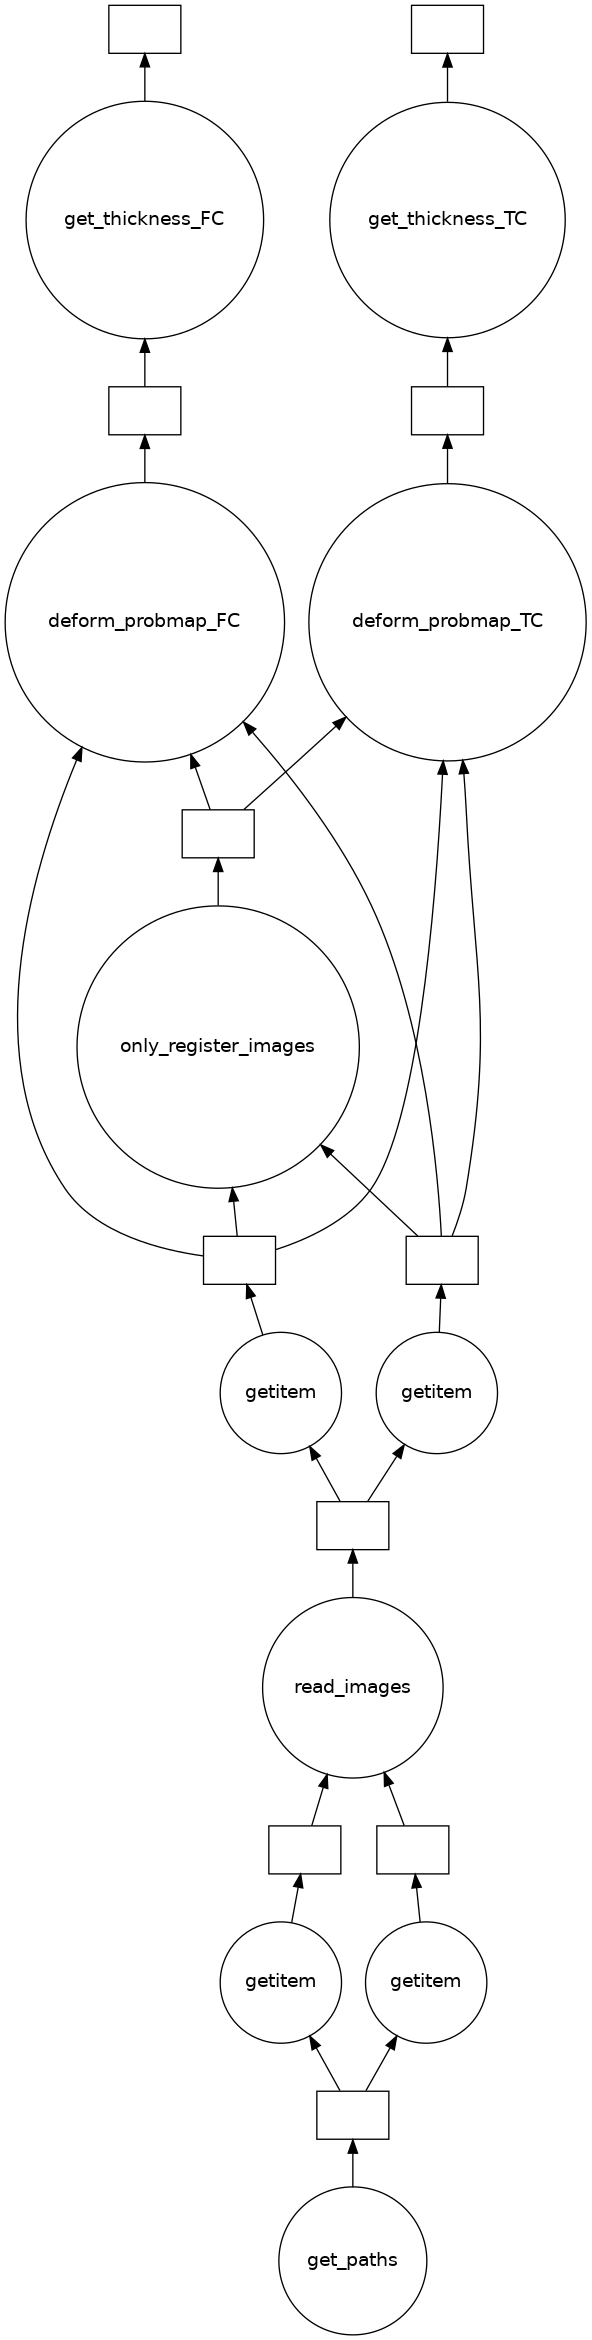

In [5]:
# Visualize Dask Computation Graph

visualize(*result)

**Note:** Try to minimize computing.

In [ ]:
%%time

l = compute(*result)

In [ ]:
![DaskProgress.png](attachment:DaskProgress.png)

In [10]:
# Write the result meshes

distance_inner_FC = l[0]
distance_inner_TC = l[1]

itk.meshwrite(distance_inner_FC, 'itk_distance_inner_FC.vtk')
itk.meshwrite(distance_inner_TC, 'itk_distance_inner_TC.vtk')

In [11]:
# Visualize the meshes with thickness as cell data

a1 = vtk.vtkPolyDataReader()
a1.SetFileName('itk_distance_inner_FC.vtk')
a1.Update()
distance_inner_FC = a1.GetOutput()

itkwidgets.view(geometries=[distance_inner_FC])

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…